# 1. Summary of the research paper



In order to sample from Bayesian posteriors we oftern use MCMC algorithms. A popular choice is to use MH algo where a move form $x$ to $y$ is accepted with a certain probability. But we can get the same stationary  distribution $\pi$ by using many other acceptance probabilities. One of them is Barker's algo, which is easier to implement but is not used much because its variance is  not as good  as that of MH algo. However it is not worse than twice of the varience if samples obtained from MH algo, so if MH algo is difficult to implement, we may use Barker's algo. But most of these algos need to evalute the acceptance ratio which generally is a function of the ratio of the target diatribution evaluated at certain points. The goal of the paper is to use Bernoulli factories to avoid explicit computaion of the acceptace probability. The paper suggests acceptance probability of the form $\alpha(x,y)=\frac{\pi(y)q(y,x)}{\pi(x)q(x,y)+\pi(y)q(y,x)+d(x,y)}$ for some $d(x,y) \geq 0$ and $d(x,y)=d(y,x)$. In Barker's algo, $d(x,y)=0$, here $\alpha$ is called $\alpha_B$.



## Barker's Method and two coin algorithm

Let us first have a look at the Barker's algo.

   1. Draw $y \sim q(x_m,dy)$
    
   2. Draw $A \sim Bern(\alpha_B(x_m,y))$.
   
   3. if $A=1$ then $x_{m+1}=y$, else $x_{m+1}=x_m$  
  
Now we have a Bernoulli factory problem, where we need to draw from $Bern(\alpha_B(x_m,y))$. We find $c_x$ and $p_x$ such that $\pi(x)q(x,y) \leq c_x$ and then set $p_x=\pi(x)q(x,y)c_x^{-1}$ similarly find $c_y,p_y$. Then $\alpha_B(x,y) = \frac{c_yp_y}{c_xp_x + c_yp_y}$. We have already seen in a previous assignment that Algorithm 2 (The two coin algo) of the paper return $1$ with probability $\alpha_B$ with mean execution time(expeccted number of iterations) equal to $\frac{c_x+c_y}{c_xp_x+c_yp_y}$. It can be seem that the mean execution time increases if the bounds $c_x$ and $c_y$ are loose.  

## Portkey Barker's Method

The main problem we still have is the inefficiency of the two coin algorithm. So we will now use PortkeyBarker's method. We have a result that for $\alpha(x,y)$ as defined in section 1, a Markov chain with acceptance probability $\alpha(x,y)$ is $\pi$-reversible iff $d(x,y)=d(y,x)$. This is statistically less efficient than Barkers's method but has immense computational gains.  For $0<\beta \leq 1$ we have the following portkey Barker's acceptance probability: $\alpha_{\beta}(x,y)=\frac{\pi(y)q(y,x)}{\pi(x)q(x,y)+\pi(y)q(y,x)+\frac{1-\beta}{\beta}(c_x+c_y)}$. We then have the $Portkey two-coin algorithm (Algorithm 3)$. We have a result that it outputs $1$ with probability $\alpha_{\beta}(x,y)$ as defined above. The mean expectation time in this case is $(1-\beta)+\beta \frac{c_xp_x + c_yp_y}{c_x+c_y}$. We can see that the ratio of  mean execution time for two coin algo and portkey two coin algo is always greater than $1$ and in fact it diverges  if $\frac{c_xp_x + c_yp_y}{c_x+c_y} \approx 0$. 
We also have some variance bounds for both the algorithms. They are : 

   1. For $0 < \beta \leq 1$, $\alpha_{(\beta)}(x,y)\leq \beta \alpha_B(x,y)$. And $var(g, P_B) \leq \beta var(g, P_{(β)}) + (\beta − 1)Var_{\pi}(g)$.
   
   2. If there is a $\delta>0$ such that $min(p_x,p_y)>\delta$ then $\alpha_{(\beta)}(x,y)\leq (1+\frac{1-\beta}{\beta \delta}) \alpha_B(x,y)$ and $var(g, P_{(\beta)}) \leq (1+\frac{1-\beta}{\delta \beta}) var(g, P_B) + \frac{1-\beta}{\delta \beta}Var_{\pi}(g)$.

## Flipped portkey two-coin algorithm

Sometimes it is easier to lower bound $\pi(x)q(x,y)$ or equivalently, upper bound $\pi(x)^{-1}q(x,y)^{-1}$. Suppose we have $\tilde{c}_x>0$ and $0<\tilde{p}_x<1$, with $\pi(x)^{-1}q(x,y)^{-1}=\tilde{c}_x\tilde{p}_x$. We can define a new acceptance probability $\alpha_{f,(\beta)}(x,y)$ with $d(x,y)=\frac{1-\beta}{\beta}\frac{\tilde{c}_x +\tilde{c}_y}{\tilde{c}_x \tilde{p}_x \tilde{c}_y \tilde{p}_y}$. We then have Algorithm 4 which outputs $1$ with probability $\alpha_{f,(\beta)}(x,y)$. Algorithm 4 yields a $\pi$-reversible markov chain and also by setting $\beta=1$ we get a new bernoulli factory for Barker's algorithm.

# Solution to problem 2

In [47]:
using Distributions
using Statistics
using Plots
using SpecialFunctions
using StatsPlots
using StatsBase

In [48]:
k = 10
nu = Gamma(10, 1/100)

Gamma{Float64}(α=10.0, θ=0.01)

In [51]:
function portkey(x,y,c_x, c_y, beta)
    while true
        S = rand(Bernoulli(beta))
        if S == 0
            return 0
        end
        c1 = rand(Bernoulli(c_y/(c_x+c_y)))
        if c1 == 1
            lambda = rand(nu)
            p_y = pdf(Weibull(k,lambda),y)/c_y
            c2 = rand(Bernoulli(p_y))
            if c2 == 1
                return 1
            end
            if c2 ==  0
                continue
            end
        end
        if c1 == 0
            lambda = rand(nu)
            p_x = pdf(Weibull(k,lambda),x)/c_x
            c2 = rand(Bernoulli(p_x))
            if c2 == 1
                return 0
            end
            if c2 == 0
                continue
            end
        end
    end          
end

portkey (generic function with 1 method)

In [52]:
function Barker(n,beta)
    arr = ones(n,1)
    arr[1] = 0.1
    for i in 2:n
        y = rand(Normal(arr[i-1],sqrt(0.001)))
        if y<0
            arr[i] = arr[i-1]
            continue
        end
        c_x = k/(exp(1)*arr[i-1])
        c_y = k/(exp(1)*y)
        
        X = portkey(arr[i-1],y,c_x, c_y, beta)
        
        if X == 0
            arr[i] = arr[i-1]
        end

        if X == 1
            arr[i] = y
        end
        
    end
    
    return arr
end

Barker (generic function with 1 method)

In [56]:
betas = [1, 0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.70 , 0.50]

trace_plots=[]
autocor_plots=[]

for beta in betas
    arr = Barker(10000, beta)
    trace_plot = plot(arr, title=beta)
    autocor_plot = plot(autocor(arr), title=beta)
    push!(trace_plots,trace_plot)
    push!(autocor_plots, autocor_plot)
end

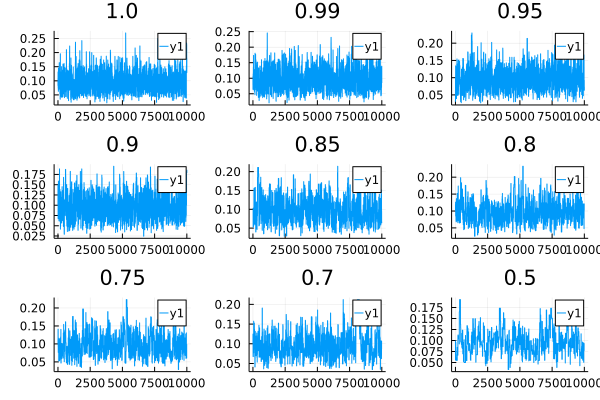

In [57]:
plot(trace_plots...)

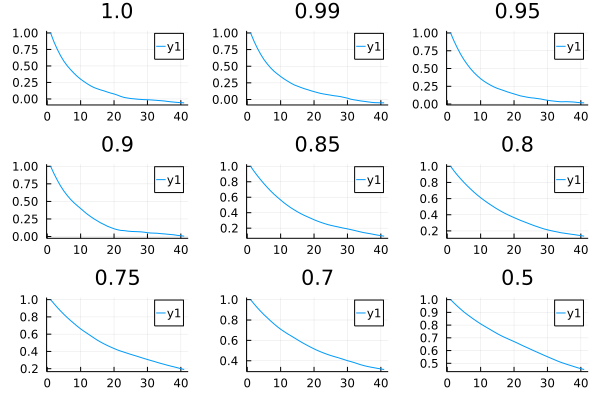

In [58]:
plot(autocor_plots...)